# Project 2 - Ames Housing Data and Kaggle Challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from collections import Counter
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

## EDA and Data Cleaning

### 1) Import and combine Test and Train data sets

In [73]:
df = pd.read_csv('./datasets/train.csv')
X_predict=pd.read_csv('./datasets/test.csv')
print(df.shape)
print(X_predict.shape)


#X_predict has 1 column lesser as it does not have 'saleprice'.
df.columns.difference(X_predict.columns)

(2051, 81)
(879, 80)


Index(['SalePrice'], dtype='object')

In [74]:
X_predict['SalePrice']=0

In [75]:
X_predict.shape

(879, 81)

In [76]:
X_predict.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,New,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,WD,0
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,2009,WD,0


In [77]:
df_combined=df.append(X_predict)
df_combined.shape

(2930, 81)

In [78]:
# Change column to lowercase and replace white space with '_'
df_combined.columns = map(str.lower, df_combined.columns)
df_combined.columns = df_combined.columns.str.replace(' ', '_')


In [79]:
#  MS_SubClass should be categorical but encoded as numeric. Converted MS_SubClass to 'object'.
df_combined['ms_subclass']=df_combined['ms_subclass'].astype('object')


In [80]:
# Drop 'id' and 'pid' as they do not affect the target
df_combined.drop(columns=['id','pid'],axis=1,inplace=True)

### 2) Missing values

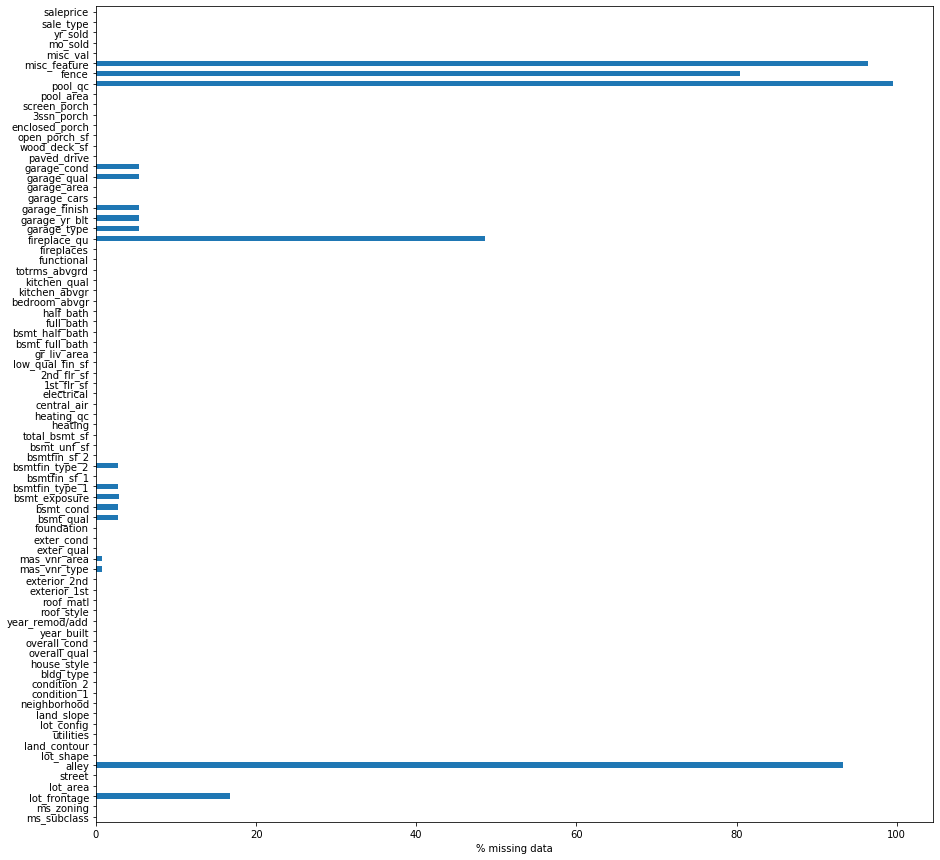

In [81]:
# Check for nulls in columns
df_null=df_combined.isnull().sum()*100/(df_combined.shape[0])
plt.figure (figsize=(15,15))
ax=df_null.plot.barh();
ax.set_xlabel("% missing data");

In [82]:
# Define function to drop columns with missing value higher than X percent
def missing_values(df, percentage):

    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    df = df.drop(missing_drop, axis=1,inplace=True)
    return df

In [83]:
# To apply function to drop columns with missing values higher than 70%. 
missing_values(df_combined, 70)
print('Number of features: ', df_combined.shape[1])

Number of features:  75


Given the high proportion (more than 70%) of missing values, these features will likely have limited variation with sale price. Hence, they are excluded at this stage. 4 features (misc_feature, fence, pool_qc and alley) were removed.

In [84]:
# Check for remain nulls in the categories
df_combined.isnull().sum().sort_values(ascending=False).head(10)

fireplace_qu      1422
lot_frontage       490
garage_finish      159
garage_yr_blt      159
garage_cond        159
garage_qual        159
garage_type        157
bsmt_exposure       83
bsmtfin_type_2      81
bsmt_qual           80
dtype: int64

In [85]:
# Number of categorical and numerical columns in df
df_combined = df_combined.apply(lambda x: x.fillna('none') if x.dtype=='O' else x.fillna(0))
df_combined.shape

(2930, 75)

The nulls in dataset do not seem to be random. For example, all features related to garage have almost the same number of missing values. This means that garage could be totally missing for those houses. Hence, the missing values are filled with 'none' or '0'. However, this imputation had negatively skewed some of the feature distributions as the distribution is concentrated at zeros.

In [86]:
# Distribution of numerical values
df_combined.pool_area.value_counts()

0      2917
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
480       1
444       1
368       1
228       1
144       1
Name: pool_area, dtype: int64

### 3) Convert ordinal data to integers

In [87]:
# Convert ordinal categories from string to integer. This can reduce the number of dummies variable created later.

# exter_qual, exter_cond, kitchen_qual, heating_qc, bsmt_cond, bsmt_qual, garage_qual
group1_cols_dict = {'Ex': 5,
               'Gd' : 4,
               'TA' : 3,
               'Fa' : 2,
               'Po' : 1,
                'none' : 0}

df_combined.exter_qual=[group1_cols_dict[item] for item in df_combined.exter_qual]
df_combined.exter_cond=[group1_cols_dict[item] for item in df_combined.exter_cond]
df_combined.kitchen_qual=[group1_cols_dict[item] for item in df_combined.kitchen_qual]
df_combined.fireplace_qu=[group1_cols_dict[item] for item in df_combined.fireplace_qu]
df_combined.heating_qc=[group1_cols_dict[item] for item in df_combined.heating_qc]
df_combined.bsmt_cond=[group1_cols_dict[item] for item in df_combined.bsmt_cond]
df_combined.bsmt_qual=[group1_cols_dict[item] for item in df_combined.bsmt_qual]
df_combined.garage_qual=[group1_cols_dict[item] for item in df_combined.garage_qual]


#lot_shape
dict_lot_shape={'Reg' : 4,
            'IR1' : 3,
            'IR2' : 2,
            'IR3' : 1,
            'none' : 0}
df_combined.lot_shape=[dict_lot_shape[item] for item in df_combined.lot_shape]

# utilities
dict_utilities={'AllPub' : 4,
            'NoSewr' : 3,
            'NoSeWa' : 2,
            'ELO' : 1,
            'none' : 0}
df_combined.utilities=[dict_utilities[item] for item in df_combined.utilities]

# land_slope
dict_land_slope = {'Gtl' : 3,
               'Mod' : 2,
               'Sev' : 1,
                'none' : 0}
df_combined.land_slope=[dict_land_slope[item] for item in df_combined.land_slope]

# bsmt_exposure
dict_bsmt_exposure = {'Gd' : 4,
               'Av' : 3,
               'Mn' : 2,
               'No' : 1,
                'none' : 0}

df_combined.bsmt_exposure=[dict_bsmt_exposure[item] for item in df_combined.bsmt_exposure]

# bsmtfin_type_1, bsmtfin_type_2
dict_bsmtfin={'GLQ' : 6,
            'ALQ' : 5,
            'BLQ' : 4,
            'Rec' : 3,
             'LwQ' : 2,
             'Unf' : 1,
            'none' : 0}
df_combined.bsmtfin_type_1=[dict_bsmtfin[item] for item in df_combined.bsmtfin_type_1]
df_combined.bsmtfin_type_2=[dict_bsmtfin[item] for item in df_combined.bsmtfin_type_2]

#garage_finish
dict_garage_finish = {'Fin' : 3,
               'RFn' : 2,
               'Unf' : 1,
                'none' : 0}
df_combined.garage_finish=[dict_garage_finish[item] for item in df_combined.garage_finish]

# electricity
dict_electrical = {'SBrkr' : 5,
             'FuseA' : 4,
              'FuseF' : 3,
              'FuseP' : 2,
              'Mix' : 1,
                'none' : 0}
df_combined.electrical=[dict_electrical[item] for item in df_combined.electrical]

# functional
dict_functional = {'Typ' : 8,
              'Min1' : 7,
              'Min2' : 6,
              'Mod' : 5,
              'Maj1' : 4,
              'Maj2' : 3,
              'Sev' : 2,
              'Sal' : 1,
                'none' : 0}
df_combined.functional=[dict_functional[item] for item in df_combined.functional]

# paved_drive
dict_paved_drive = {'Y' : 3,
              'P' : 2,
              'N' : 1,
                'none' : 0}
df_combined.paved_drive=[dict_paved_drive[item] for item in df_combined.paved_drive]


In [88]:
df_combined.shape

(2930, 75)

In [89]:
df_combined=pd.get_dummies(df_combined, drop_first=True)
df_combined.shape

(2930, 201)

### 4) Reject features with p-value greater than 0.05

In [90]:
# Selecting columns based on p-value. Reject columns if p-value is greater than 0.05.
selected_columns=df_combined.columns[:-1].values

def backwardelimination(x,Y,sl,columns):
    numVars=len(x[0])
    for i in range(0,numVars):
        regressor_OLS=sm.OLS(Y,x).fit()
        maxVar=max(regressor_OLS.pvalues).astype(float)
        if maxVar>sl:
            for j in range(0,numVars-i):
                if (regressor_OLS.pvalues[j].astype(float)==maxVar):
                    x=np.delete(x,j,1)
                    columns=np.delete(columns,j)
                    regressor_OLS.summary()
                    return x, columns
sl=0.05
data_modeled,selected_columns=backwardelimination(df_combined.iloc[:,:-1].values,df_combined.iloc[:,-1].values,sl,selected_columns)

In [91]:
selected_columns=pd.DataFrame(data_modeled,columns=selected_columns)
print('Features not significant enough to impact saleprice: ',df_combined.columns.difference(selected_columns.columns))

Features not significant enough to impact saleprice:  Index(['enclosed_porch', 'sale_type_WD '], dtype='object')


In [92]:
df_combined.drop(columns=['enclosed_porch', 'sale_type_WD '],inplace=True)
print(df_combined.shape)

(2930, 199)


In [93]:
# Split df_combined to Train and Test(for prediction)
df_train=df_combined[df_combined.saleprice>0]
df_test=df_combined[df_combined.saleprice==0]
print(df_train.shape)
print(df_test.shape)

(2051, 199)
(879, 199)


### 5) Evaluate top correlations and distribution of sale price

C:\Users\frl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frl\Anaconda3\lib\site-packages\pandas\core\frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


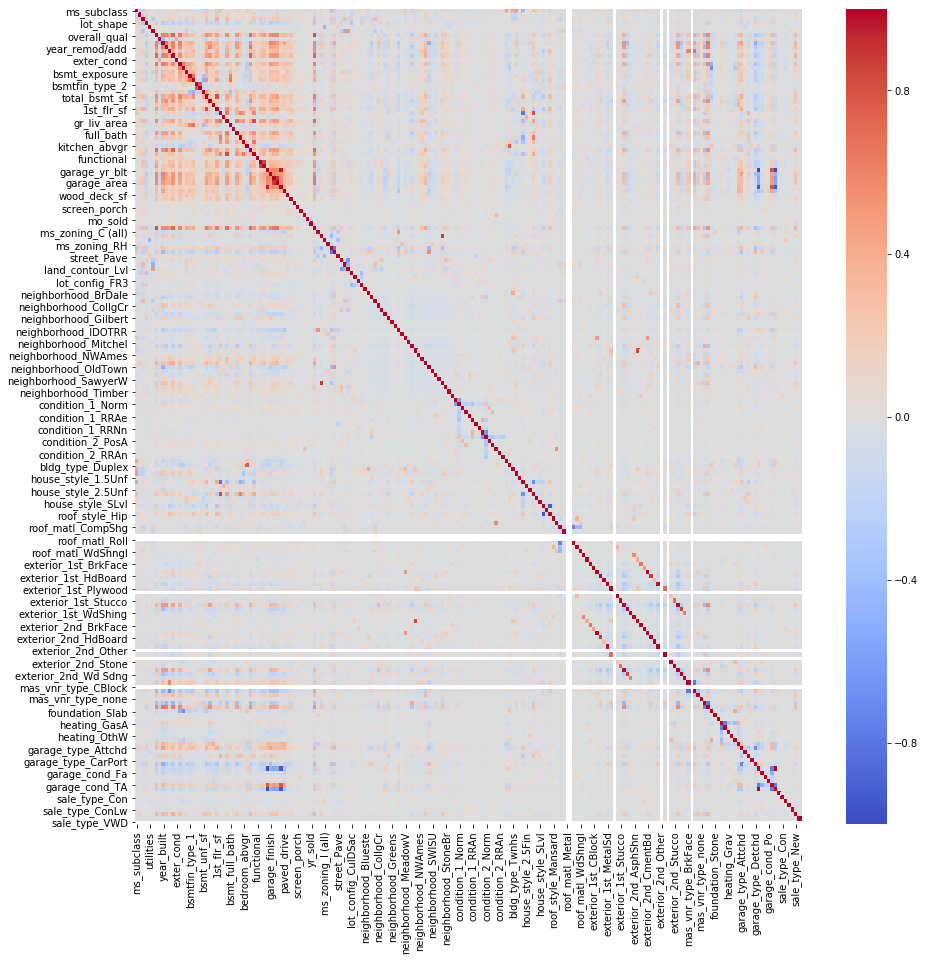

In [94]:
# Heatmap to view the correlations between features
df_train_corr = df_train.corr()
df_train[np.abs(df_train_corr)<.5] = 0
plt.figure(figsize=(15,15))
sns.heatmap(df_train_corr,
            vmin=-1,
            vmax=1,
            cmap='coolwarm');

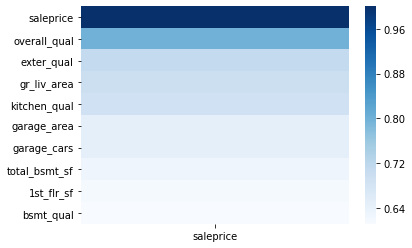

In [95]:
# Create heatmap to track the 9 most correlated features to sale price
top_corr=np.abs(df_train.corr()[['saleprice']]).sort_values('saleprice',ascending=False);
sns.heatmap(top_corr.head(10),cmap='Blues');

While correlation provided an overview on the top correlated features, lasso or ridge regression should be used for actual regression. Correlation is unable to eliminate collinearity effect as there are some features that are highly correlated with each other. For example, garage_area and garage_cars are expected to be highly correlated.

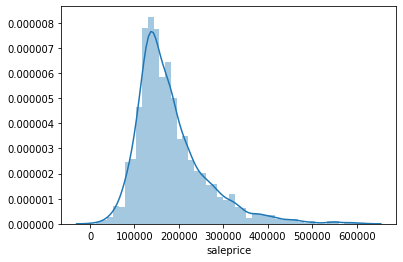

In [96]:
# Distribution plot of sale price in df_train
sns.distplot(df_train['saleprice']);
ax.set_title('Distribution of df_train sale price');

From the distribution plot and boxplot, sale price is positively skewed. This is caused by a small number of super expensive houses. To minimise the skewness

### 6) Identify and remove outliers

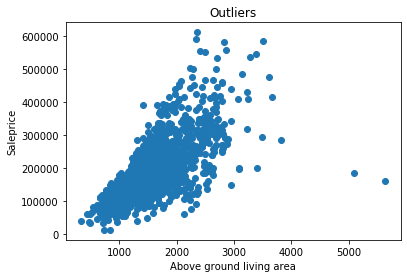

In [97]:
plt.scatter(df_train['gr_liv_area'],df_train['saleprice']);
plt.title('Outliers');
plt.xlabel('Above ground living area');
plt.ylabel('Saleprice');


In [98]:
df_train.shape

(2051, 199)

In [99]:
# Identify the outliers
df_train[df_train['gr_liv_area']>4500]

,ms_subclass,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,...,garage_cond_TA,garage_cond_none,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD
960,60,313.0,63887,1,4,3,10,5,2008,2008,...,1,0,0,0,0,0,0,1,0,0
1885,20,128.0,39290,3,4,3,10,5,2008,2009,...,1,0,0,0,0,0,0,1,0,0


Based on the row index, the two outliers are within Train set so they can be removed.

In [65]:
# Dropped two outliers that have gr_liv_area greater than 4500sf 
df_train=df_train[df_train['gr_liv_area']<4500]

In [66]:
df_train.shape

(2049, 199)

Given that living area is an important feature (highly correlated to sale price), its outliers may potentially skew the model. Hence, the two outliers are removed.

## Model

### 1) Train test split

In [100]:
# Further split df_train to X and y.
X=df_train.drop(columns=['saleprice'],axis=1)
y=df_train['saleprice']
X_pred=df_test.drop(columns=['saleprice'],axis=1)

In [114]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=42)

### 2) Scale data

In [115]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_pred_scaled=scaler.transform(X_pred)

In [116]:
X_train.shape

(1845, 198)

In [117]:
# Instantiate three regression models
lr = LinearRegression()
lasso = LassoCV(n_alphas=1000)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

### 3) Cross Validation

In [118]:
# Cross validation to evaluate all three models
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=10)
lr_scores.mean()

-8.708571617860986e+19

In [119]:
lasso_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=10)
lasso_scores.mean()

C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarni

0.8358198702677357

In [107]:
ridge_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=10)
ridge_scores.mean()

0.8115330131899328

Lasso regression gives the highest R squared so it is choosen for further fitting.

### 4) Lasso regression

In [108]:
# Model fitting and evaluation. LassoCV seems to be doing the best.
# Fit Lasso model to training data and evaluate the training and test scores.
optimal_lasso=LassoCV(n_alphas=1000,cv=10,verbose=1, random_state=42)
lasso_model=optimal_lasso.fit(X_train_scaled,y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

795.1062286071291


....................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


In [120]:
y_fit = lasso_model.predict(X_train_scaled)

In [121]:
residuals_1=y_fit-y_train

In [122]:
r2_score(y_train, y_fit)

0.8917045151072097

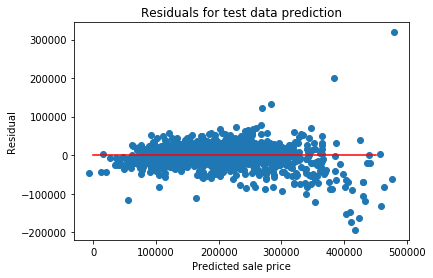

In [123]:
plt.scatter(y_fit,residuals_1);
plt.plot([0,np.max(y_test)],[0,0],c='r')
plt.title('Residuals for test data prediction');
plt.ylabel('Residual');
plt.xlabel('Predicted sale price');

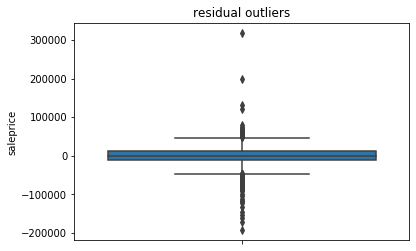

In [124]:
B=sns.boxplot(residuals_1,orient='v').set_title('residual outliers')

In [125]:
lasso_score=lasso_model.score(X_train_scaled,y_train)
lasso_score

0.8917045151072097

In [126]:
pred = lasso_model.predict(X_test_scaled)

In [127]:
r2_score(y_test, pred)

0.8950531762189794

The R squared for test data is slightly lower than train data. This means Lasso model contain certain amount of variance and reasonable bias (R2~0.8).

In [128]:
from math import sqrt

print('Calculated RMSE: ', sqrt(mean_squared_error(y_test, pred)))


Calculated RMSE:  24856.19870719681


In [129]:
residuals=y_test-pred

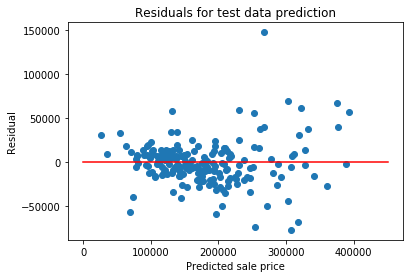

In [130]:
plt.scatter(pred,residuals);
plt.plot([0,np.max(y_test)],[0,0],c='r')
plt.title('Residuals for test data prediction');
plt.ylabel('Residual');
plt.xlabel('Predicted sale price');

Skewness of residuals: 1.0168428910848248
Kurtosis of residuals: 6.808362091399459


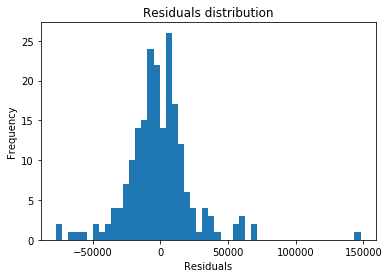

In [131]:
plt.hist(residuals, bins=50);
print('Skewness of residuals:', residuals.skew())
print('Kurtosis of residuals:',residuals.kurtosis())
plt.title('Residuals distribution');
plt.ylabel('Frequency');
plt.xlabel('Residuals');

The residual plot does not appear to be a normal distribution. 

In [132]:
# List top and bottom lasso coefficients
features=[col for col in X_train.columns]
lasso_coef=pd.Series(lasso_model.coef_,index=features).sort_values(ascending=False)
print(lasso_coef.head(10))
print(lasso_coef.tail(10))


gr_liv_area             17092.004533
overall_qual            13627.365173
neighborhood_NridgHt     9853.400545
neighborhood_StoneBr     7466.890360
exter_qual               6672.183191
bsmt_exposure            5519.485140
neighborhood_NoRidge     5423.123472
kitchen_qual             5378.166005
garage_cars              4396.157865
screen_porch             4214.976092
dtype: float64
land_slope              -935.180090
exterior_1st_Wd Sdng    -986.693978
exterior_1st_HdBoard   -1103.324798
roof_style_Mansard     -1224.595172
exterior_1st_Stucco    -1435.595539
neighborhood_Edwards   -2022.572441
pool_area              -2273.965797
bldg_type_TwnhsE       -2318.872875
misc_val               -4883.039590
ms_subclass            -6444.752980
dtype: float64


In [133]:
print('Number of Lasso coefficients remaining: ',lasso_coef[lasso_coef!=0].shape[0])


Number of Lasso coefficients remaining:  84


While most of the top features selected by Lasso were also top features presented in  correlation heatmap, some features were different.For example, garage area is removed by Lasso as it is highly correlated with garage car. This shows that Lasso has taken care of the issue of collinearity.

In [134]:
print('Percent variables zeroed out(%):', np.sum((lasso_coef == 0))*100/float(X_train.shape[1]))

Percent variables zeroed out(%): 57.57575757575758


In [135]:
lasso_coef.to_csv('C:/Users/frl/Desktop/DSI13/MyDSI_11Feb/classes/project_2/datasets/lasso_submission.csv', index=False)

C:\Users\frl\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


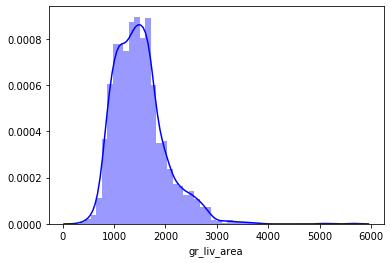

In [136]:
sns.distplot(df_train['gr_liv_area'], color="b");

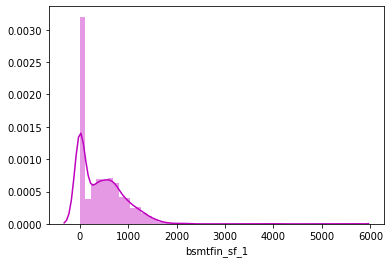

In [137]:
sns.distplot(df_train['bsmtfin_sf_1'], color="m");

Plots of distribution of the top 2 continuous features ranked by Lasso. The gr_liv_area plot looks like a normal distribution. The bmstfin_sf_1 distribution is affected by a large number of houses with 0 values for bmstfin_sf_1. The 0 values were imputed in earlier step. A better option was to impute the missing values with mean/median so as not to affect the variable distribution.

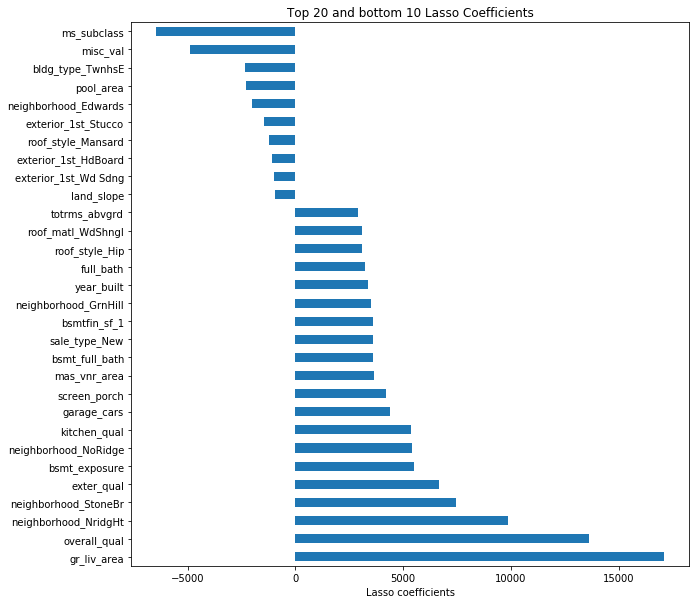

In [138]:
plt.figure(figsize=(10,10))
top_10=lasso_coef.head(20)
bottom_10=lasso_coef.tail(10)
pd.concat([top_10,bottom_10],axis=0).plot.barh(x=0,y=1)
plt.title('Top 20 and bottom 10 Lasso Coefficients');
plt.xlabel('Lasso coefficients');

In [139]:
neighborhood_lasso_coef=lasso_coef.filter(regex='^neighborhood',axis=0)

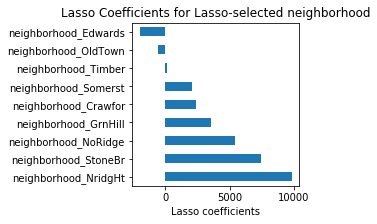

In [140]:
plt.figure(figsize=(3,3))
top_10=neighborhood_lasso_coef.head(7)
bottom_10=neighborhood_lasso_coef.tail(2)
pd.concat([top_10,bottom_10],axis=0).plot.barh(x=0,y=1)
plt.title('Lasso Coefficients for Lasso-selected neighborhood');
plt.xlabel('Lasso coefficients');

### 5) Predict target sale price

In [141]:
# Predicted sale price based on Test data set
y_pred_result= lasso_model.predict(X_pred_scaled)
y_pred_result.mean()

178239.46312082675

In [142]:
y_pred_result.shape

(879,)

In [143]:
X_predict['Id'].head()

0    2658
1    2718
2    2414
3    1989
4     625
Name: Id, dtype: int64

In [144]:
result=pd.DataFrame(y_pred_result,columns=['saleprice'])
result['Id']=X_predict['Id']
result=result[['Id','saleprice']]
result.head()

,Id,saleprice
0,2658,122515.628528
1,2718,152162.716291
2,2414,236247.998839
3,1989,113458.949705
4,625,186186.131053


In [146]:
# Save result as csv
result.to_csv('./datasets/result.csv', index=False)

Submitted result to Kaggle and scored 33686.

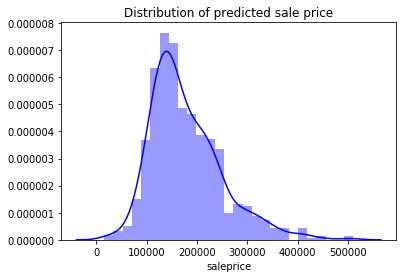

In [147]:
ax=sns.distplot(result['saleprice'], color="b");
ax.set_title('Distribution of predicted sale price');
